# Classification of EEG Recordings from Alcohol  Abuseres

Submitted by: Guy Pozner (301907325)
            Yohay, (ID)

### Aims

* Achiving High Accurcy/Recall classification of Alcohol Abuseres.
* Exploring CNN for EEG classification.
* Studying the MNE package enviorment.

### Rationale

According to the World Health Organization, Alcohol abuse is the cause of over 3 milion deaths worldwide each year, and is a causl factor in more than 200 diseases. Patients with alcohol use disorders are often classfied as such by a clinition using subjective measures(DSM-V). The development of an accurate clasiffier will establish an objective standard by which scientists and clinitions will be able to research and treat alcohol abusers. Further more, the classification of the EEG of alcohol abuser will allow scientists to model and better understand the brain of alcohol abusers.

### The Dataset


The dataset was curated by a large study to find correlates between EEG measurements and genetic predisposition to alcohol. It contains EEG recordings from 122 subjects, where each subject perfomed multiple trails. Each trails is 1s long and is recorded at 256Hz from 64 electrodes, using the 10-20 standard for the elctrode positions. The original study used 3 different visual stimulations. One showing a single object, called S1, one showing two matching objects, called S2 match, and one showing two non matching objects, called S2 no match.

* Data example below

In [156]:
from extract_load_eeg_dataset import read_all_trails
import mne
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 2019

In [2]:
# The dataset is loaded as a list of 5-tuple,
# were each 5-tuple has the following structure,
# (subject_num, trail_num, stim_type, trail_stims, is_alcoholic).
dirpath = 'eeg_full'
dataset = read_all_trails(dirpath)

co2c1000367.rd.089.rd corrupted
co2c1000367.rd.005.rd corrupted
co2c1000367.rd.114.rd corrupted
co2c1000367.rd.054.rd corrupted
co2c1000367.rd.004.rd corrupted
co2c1000367.rd.105.rd corrupted
co2c1000367.rd.065.rd corrupted
.Rhistory corrupted


In [35]:
# Setting up the channel names for the mne visualizations
with open(dirpath + '/co2a0000375/co2a0000375.rd.003.rd', 'r') as f:
    channel_names = []
    for _ in range(4):
        next(f)
    for line in f:
        parsed_line = line.split(' ')
        if parsed_line[0] == '#':
            channel_names.append(parsed_line[1])

# Setting up the info object for the mne.EpochsArray
sampling_freq = 256
info = mne.create_info(ch_names=channel_names,
                       sfreq=sampling_freq,
                       ch_types=['eeg']*64, montage = 'standard_1020')

# Setting mne epochs array for the visiualization
# of subject's 461 EEG recordings under 
# the 3 different stimulations.
epochs_list_s1 = []
epochs_list_s2 = []
epochs_list_s2_no = []
for data in dataset:
    if data[0] == '461':
        if data[2] == 'S1 obj':
            epochs_list_s1.append(data[3])
        elif data[2] == 'S2 match':
            epochs_list_s2.append(data[3])
        else:
            epochs_list_s2_no.append(data[3])

epochs_arr_s1 = mne.EpochsArray(epochs_list_s1, info)
epochs_arr_s2 = mne.EpochsArray(epochs_list_s2, info)
epochs_arr_s2_no = mne.EpochsArray(epochs_list_s2_no, info)

evoked_s1 = epochs_arr_s1.average()
evoked_s2 = epochs_arr_s2.average()
evoked_s2_no = epochs_arr_s2_no.average()

6 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<ipython-input-35-ad43698caafc>:25: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['X', 'nd', 'Y']. Their position has been left untouched.
  ch_types=['eeg']*64, montage = 'standard_1020')


12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


### S1 stimualation example

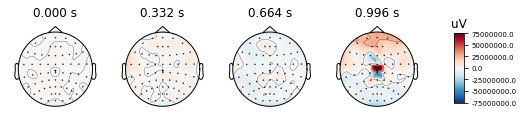

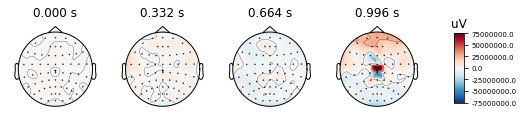

In [38]:
evoked_s1.plot_topomap()

### S2 match stimualation example

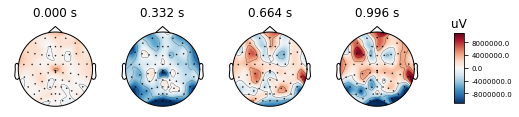

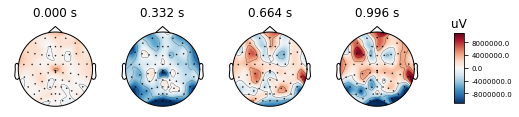

In [47]:
evoked_s2.plot_topomap()

### S2 no match stimualation example

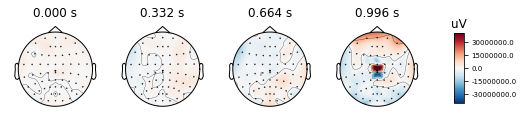

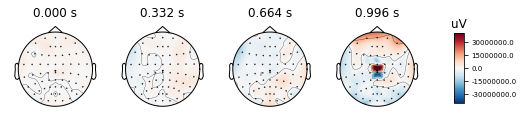

In [40]:
evoked_s2_no.plot_topomap()

### Approach

In this project we will classify each trail as recorded from alcohol abuser or control, assuming that there is a difference in the EEG recordings of alcohol abusers vs. cotrols which is independent of stimulation type.

#### Pipeline:
1. Use ICA to extract independent components.
2. Apply FFT to extract the spectrogram of each component of each trail.
3. Use a convolutional neural network to classify the spectrograms.

### Perliminary results

We will establish a simple baseline model in order to test if a convolutional neural network will improve our results.

In [186]:
# Setting up the dataset into numpy arrays
# And mne epochs
trails = []
labels = []
for data in dataset:
    trails.append(data[3])
    labels.append(data[4])
    
trails = np.array(trails)
labels = np.array(labels)

epochs = mne.EpochsArray(trails, info)

1361 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [187]:
# Filter and apply ICA to each trail
epochs = epochs.filter(1., 40., method = 'iir')
X = epochs.get_data()
ica = FastICA(n_components = 3, random_state = RANDOM_STATE, max_iter = 50)
X_transformed = np.array([ica.fit_transform(x.T) for x in X])

Setting up band-pass filter from 1 - 40 Hz


In [188]:
# Classify using logistic regression
X_transformed_flatten = np.array([x.flatten() for x in X_transformed])
y = np.array(labels)

# Train\Test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed_flatten,
                                                   y,
                                                   test_size=0.3,
                                                   random_state = RANDOM_STATE)

# Fit the logistic regression classfier
clf = LogisticRegression(random_state = RANDOM_STATE).fit(X_train, y_train)

In [191]:
clf.score(X_test, y_test)

0.5696821515892421